In [1]:
from collections import Counter
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from pymutspec.draw import plot_mutspec12
from pymutspec.annotation import CodonAnnotation
from pymutspec.constants import possible_codons
from pymutspec.io import read_genbank_ref

from scipy.spatial.distance import euclidean, cityblock
from scipy.stats import chisquare, ks_2samp, pearsonr, spearmanr, uniform
from scipy.special import kl_div
from sklearn.metrics import mean_squared_error, r2_score
import tqdm

from utils import (
    amino_acid_codes, alphabet, cdn_spectrum_to_matrix, 
    nuc_spectrum_to_matrix, collect_possible_changes,
    get_equilibrium_probabilities, plot_exp_heatmap,
    prepare_aa_subst, plot_aa_eq_freqs, prepare_exp_aa_subst,
    calc_metrics,weighted_average_percentage_error, get_equilibrium_freqs
)

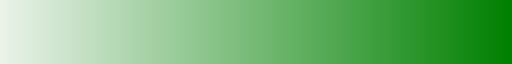

In [2]:
sns.color_palette("light:green", as_cmap=True)

In [3]:
coda = CodonAnnotation(1)

## Load reference and calc amino acid freqs

In [4]:
from Bio import SeqIO
rec = next(SeqIO.parse("data/NC_045512.2.gb", "genbank"))

In [5]:
ref_df = pd.DataFrame([f.qualifiers for f in rec.features if f.type == "CDS"])
ref_df.drop(columns=["locus_tag", "ribosomal_slippage", "codon_start", 
                     "db_xref", 'gene_synonym'], inplace=True)
ref_df["gene"] = ref_df["gene"].apply(lambda x: x[0])
ref_df["product"] = ref_df["product"].apply(lambda x: x[0])
ref_df["protein_id"] = ref_df["protein_id"].apply(lambda x: x[0])
ref_df["translation"] = ref_df["translation"].apply(lambda x: x[0])

orf1ab = ref_df.loc[0, "translation"]
orf1a = ref_df.loc[1, "translation"]
assert orf1ab[:4401] == orf1a[:4401]
orf1b = orf1ab[4401:]

ref_df.loc[0, "translation"] = orf1b
ref_df.loc[1, "gene"] = 'ORF1a;ORF1ab'

ref_df["size"] = ref_df["translation"].str.len()
# ref_df = ref_df[ref_df['product'] != 'ORF1a polyprotein']
ref_df.to_csv('./data/ref_proteins.csv', index=False)
ref_df

,gene,note,product,protein_id,translation,size
0,ORF1ab,[pp1ab; translated by -1 ribosomal frameshift],ORF1ab polyprotein,YP_009724389.1,RVCGVSAARLTPCGTGTSTDVVYRAFDIYNDKVAGFAKFLKTNCCR...,2695
1,ORF1a;ORF1ab,[pp1a],ORF1a polyprotein,YP_009725295.1,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...,4405
2,S,[structural protein; spike protein],surface glycoprotein,YP_009724390.1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1273
3,ORF3a,NaN,ORF3a protein,YP_009724391.1,MDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWL...,275
4,E,[ORF4; structural protein; E protein],envelope protein,YP_009724392.1,MYSFVSEETGTLIVNSVLLFLAFVVFLLVTLAILTALRLCAYCCNI...,75
5,M,[ORF5; structural protein],membrane glycoprotein,YP_009724393.1,MADSNGTITVEELKKLLEQWNLVIGFLFLTWICLLQFAYANRNRFL...,222
6,ORF6,NaN,ORF6 protein,YP_009724394.1,MFHLVDFQVTIAEILLIIMRTFKVSIWNLDYIINLIIKNLSKSLTE...,61
7,ORF7a,NaN,ORF7a protein,YP_009724395.1,MKIILFLALITLATCELYHYQECVRGTTVLLKEPCSSGTYEGNSPF...,121
8,ORF7b,NaN,ORF7b,YP_009725318.1,MIELSLIDFYLCFLAFLLFLVLIMLIIFWFSLELQDHNETCHA,43
9,ORF8,NaN,ORF8 protein,YP_009724396.1,MKFLVFLGIITTVAAFHQECSLQSCTQHQPYVVDDPCPIHFYSKWY...,121


In [6]:
aa_freqs_df = pd.DataFrame(ref_df.set_index('gene')['translation']\
                           .apply(Counter).to_dict()).T.fillna(0).astype(int)
aa_freqs_df.to_csv('./data/ref_aa_freqs.csv')
aa_freqs_df

,R,V,C,G,S,A,L,T,P,D,Y,F,I,N,K,Q,E,H,M,W
ORF1ab,113,228,88,149,162,179,233,182,110,178,140,142,128,151,158,88,101,70,63,32
ORF1a;ORF1ab,131,371,138,264,294,309,435,345,164,211,195,208,215,233,276,151,239,75,105,46
S,42,97,40,82,99,79,108,97,58,62,54,77,76,88,61,62,48,17,14,12
ORF3a,6,25,7,14,22,13,30,24,12,13,17,14,21,8,11,9,11,8,4,6
E,3,13,3,1,8,4,14,4,2,1,4,5,3,5,2,0,2,0,1,0
M,14,12,4,14,15,19,35,13,5,6,9,11,20,11,7,4,7,5,4,7
ORF6,1,3,0,0,4,1,8,3,1,4,2,3,10,4,4,3,5,1,3,1
ORF7a,5,8,6,4,7,9,15,10,6,2,5,10,8,2,7,5,8,3,1,0
ORF7b,0,1,2,0,2,2,11,1,0,2,1,6,5,1,0,1,3,2,2,1
ORF8,4,12,7,5,9,5,10,5,7,7,7,8,10,2,5,6,6,4,1,1


In [7]:
# check genome size (CDS)
aa_freqs_df.sum(1).sum()*3

np.int64(29244)

In [8]:
aa_freqs_total_dct = aa_freqs_df.rename(columns=amino_acid_codes).sum(0).to_dict()

with open('data/ref_aa_freqs_mean.json', 'w') as f:
    json.dump(aa_freqs_total_dct, f)

aa_freqs_total_dct

{'Arg': 350,
 'Val': 782,
 'Cys': 296,
 'Gly': 577,
 'Ser': 661,
 'Ala': 659,
 'Leu': 930,
 'Thr': 718,
 'Pro': 394,
 'Asp': 511,
 'Tyr': 448,
 'Phe': 501,
 'Ile': 513,
 'Asn': 532,
 'Lys': 562,
 'Gln': 365,
 'Glu': 442,
 'His': 189,
 'Met': 207,
 'Trp': 111}

In [40]:
## read external clades spectra
# https://raw.githubusercontent.com/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/synonymous_mut_rates/rates_by_clade.csv

clades_spectra = pd.read_csv('data/bloom_etal/rates_by_clade.csv').query('subset == "all"')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()
spectrum_24A = clades_spectra[clades_spectra['clade'] == '24A'].copy()
spectrum_24A['rate'] /= spectrum_24A['rate'].sum()
spectrum_20A

,subset,clade,mut_type,count,total_count,fraction,parent_nt,parent_nt_frac,rate,Mut
0,all,20A,AtoC,305,18970,0.016078,A,0.289560,0.007540,A>C
1,all,20A,AtoG,1778,18970,0.093727,A,0.289560,0.043953,A>G
2,all,20A,AtoT,588,18970,0.030996,A,0.289560,0.014536,A>T
3,all,20A,CtoA,384,18970,0.020242,C,0.135130,0.020341,C>A
4,all,20A,CtoG,135,18970,0.007117,C,0.135130,0.007151,C>G
5,all,20A,CtoT,7840,18970,0.413280,C,0.135130,0.415293,C>T
6,all,20A,GtoA,878,18970,0.046284,G,0.064585,0.097310,G>A
7,all,20A,GtoC,140,18970,0.007380,G,0.064585,0.015516,G>C
8,all,20A,GtoT,2906,18970,0.153190,G,0.064585,0.322075,G>T
9,all,20A,TtoA,639,18970,0.033685,T,0.510720,0.008956,T>A


In [41]:
_clades_order = clades_spectra.drop_duplicates(subset='clade').set_index('clade')

_1 = {x:'Early clades' for x in _clades_order.loc[:'21J'].index.unique()}
_2 = {x:'Late clades\n(Omicron+)' for x in _clades_order.loc['21K':].index.unique()}

_clade2label = {**_1, **_2}
_clade2label

{'20A': 'Early clades',
 '20B': 'Early clades',
 '20C': 'Early clades',
 '20E': 'Early clades',
 '20G': 'Early clades',
 '20I': 'Early clades',
 '20J': 'Early clades',
 '21C': 'Early clades',
 '21I': 'Early clades',
 '21J': 'Early clades',
 '21K': 'Late clades\n(Omicron+)',
 '21L': 'Late clades\n(Omicron+)',
 '22A': 'Late clades\n(Omicron+)',
 '22B': 'Late clades\n(Omicron+)',
 '22C': 'Late clades\n(Omicron+)',
 '22D': 'Late clades\n(Omicron+)',
 '22E': 'Late clades\n(Omicron+)',
 '22F': 'Late clades\n(Omicron+)',
 '23A': 'Late clades\n(Omicron+)',
 '23B': 'Late clades\n(Omicron+)',
 '23C': 'Late clades\n(Omicron+)',
 '23D': 'Late clades\n(Omicron+)',
 '23F': 'Late clades\n(Omicron+)',
 '24A': 'Late clades\n(Omicron+)'}

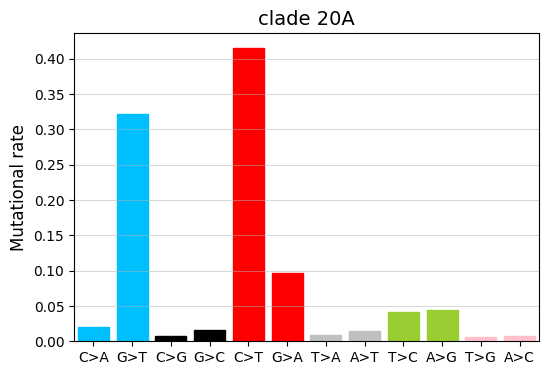

In [9]:
ax = plot_mutspec12(spectrum_20A, 'rate', 'clade 20A', 
               ylabel='Mutational rate', ticksize=10,
               savepath='./figures/20A_spectrum.pdf'
)

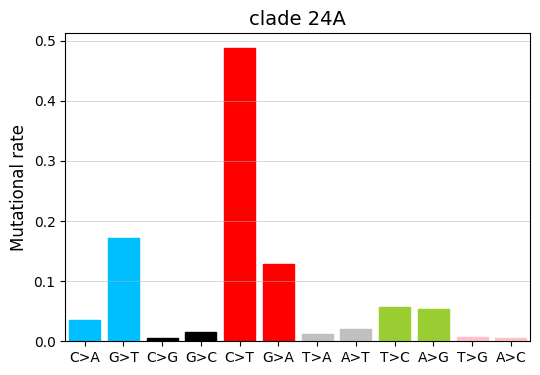

In [18]:
ax = plot_mutspec12(spectrum_24A, 'rate', 'clade 24A', 
               ylabel='Mutational rate', ticksize=10,
            #    savepath='./figures/20A_spectrum.png'
)

In [10]:
spectrum_20A_dct = spectrum_20A.set_index('Mut').rate.to_dict()
df_changes = collect_possible_changes(1, spectrum_20A_dct)

## Calculate expected AA substitutions matrix 
exp_aa_subst, exp_aa_subst_matrix = prepare_exp_aa_subst(spectrum_20A, gc=1)
exp_aa_subst.to_csv('data/20A/exp_aa_subst.csv', float_format='%g', index=False)
exp_aa_subst

,aa1,aa2,rate
0,Ala,Ala,1.000000
1,Ala,Asp,0.040682
2,Ala,Glu,0.040682
3,Ala,Gly,0.028605
4,Ala,Pro,0.062066
...,...,...,...
163,Val,Ile,0.291929
164,Val,Leu,0.706215
165,Val,Met,0.097310
166,Val,Phe,0.644149


## Estimate neutrality of the spectrum

In [9]:
from typing import Union
from Bio.SeqRecord import SeqRecord

def read_genbank_ref(gb: Union[str, SeqRecord]):
    if isinstance(gb, str):
        genome = next(SeqIO.parse(gb, "genbank"))
    elif isinstance(gb, SeqRecord):
        genome = gb
    else:
        raise NotImplementedError

    ftypes = {"CDS", "rRNA", "tRNA"}
    full_nucls = set("ACGT")
    data = []
    df: pd.DataFrame = None
    gene_qualifier = None
    for ftr in genome.features:
        if ftr.type == "source":
            source = ftr.extract(genome)
            seq = str(source.seq)
            for pos, nuc in enumerate(seq):
                context = seq[pos - 1: pos + 2]
                if len(context) < 3 or len(set(context).difference(full_nucls)) != 0:
                    context = None
                if nuc not in full_nucls:
                    nuc = context = None
                data.append({"Pos": pos + 1, "Nuc": nuc, "Context": context})
            df = pd.DataFrame(data)
            df["Strand"] = 0
            continue
        elif gene_qualifier is None and ftr.type in ftypes:
            for qualifier in ["gene", "product", "protein_id"]:
                if qualifier in ftr.qualifiers:
                    gene_qualifier = qualifier
                    break
            if gene_qualifier is None:
                raise RuntimeError(f"Cannot find any expected qualifier of feature: {ftr}; with following qualifiers: {ftr.qualifiers}")

        for pos in list(ftr.location):
            df.at[pos, "Type"] = ftr.type
            df.at[pos, "Strand"] = ftr.location.strand
            if ftr.type in ftypes:
                df.at[pos, qualifier] = ftr.qualifiers[qualifier][0]

    # add codon features
    df["PosInGene"] = -1
    df["PosInCodon"] = -1
    for gene_name in df[(df.Type == "CDS") & (df.Strand == 1)][gene_qualifier].unique():
        gdf = df[df[gene_qualifier] == gene_name]
        seq = gdf.Nuc.values
        for pos_in_gene, pos in enumerate(gdf.index):
            pic = pos_in_gene % 3
            cdn = seq[pos_in_gene - pic: pos_in_gene - pic + 3]
            cdn = "".join(cdn) if len(set(cdn).difference(full_nucls)) == 0 else None
            df.at[pos, "Codon"] = cdn
            df.at[pos, "PosInGene"] = pos_in_gene + 1
            df.at[pos, "PosInCodon"] = pic + 1

    df["Strand"] = df["Strand"].astype(np.int8)
    df["PosInCodon"] = df["PosInCodon"].astype(np.int8)
    df["PosInGene"] = df["PosInGene"].astype(np.int32)
    return df

ref_sites_df = read_genbank_ref('data/NC_045512.2.gb')
ref_sites_df = ref_sites_df[ref_sites_df.Codon.notna()]
ref_sites_df['aa'] = ref_sites_df.Codon.apply(coda.translate_codon)
# Pos and nt_site is the same
ref_sites_df

,Pos,Nuc,Context,Strand,Type,gene,PosInGene,PosInCodon,Codon,aa
265,266,A,GAT,1,mat_peptide,ORF1ab,1,1,ATG,M
266,267,T,ATG,1,mat_peptide,ORF1ab,2,2,ATG,M
267,268,G,TGG,1,mat_peptide,ORF1ab,3,3,ATG,M
268,269,G,GGA,1,mat_peptide,ORF1ab,4,1,GAG,E
269,270,A,GAG,1,mat_peptide,ORF1ab,5,2,GAG,E
...,...,...,...,...,...,...,...,...,...,...
29669,29670,C,ACA,1,CDS,ORF10,113,2,ACA,T
29670,29671,A,CAT,1,CDS,ORF10,114,3,ACA,T
29671,29672,T,ATA,1,CDS,ORF10,115,1,TAG,*
29672,29673,A,TAG,1,CDS,ORF10,116,2,TAG,*


In [10]:
obs_raw = pd.read_csv('data/bloom_etal/aggregated.csv').query('subset == "all" & exclude == False')
obs_raw['Mut'] = obs_raw['nt_mutation'].str[0] + '>' + obs_raw['nt_mutation'].str[-1]
obs_syn = obs_raw.query('synonymous == True & four_fold_degenerate == True').drop(['synonymous', 'noncoding'], axis=1)
obs_syn['aa'] = obs_syn.aa_mutation.str.get(0)
obs_syn

,protein,aa_mutation,nt_mutation,codon_change,nt_site,reference_nt,clade_founder_nt,exclude,count,count_terminal,count_non_terminal,mean_log_size,clade,subset,codon,codon_position,codon_site,four_fold_degenerate,Mut,aa
8,ORF1a;ORF1ab,V3689V;V3689V,A11332G,GTA>GTG;GTA>GTG,11332,A,A,False,42,16,26,1.066247,19A,all,GTA;GTA,3;3,3689;3689,True,A>G,V
35,S,V1264V,G25354C,GTG>GTC,25354,G,G,False,16,12,4,0.198628,19A,all,GTG,3,1264,True,G>C,V
47,ORF7a,G38G,A27507C,GGA>GGC,27507,A,A,False,13,7,6,0.421588,19A,all,GGA,3,38,True,A>C,G
66,ORF1a;ORF1ab,T1773T;T1773T,A5584G,ACA>ACG;ACA>ACG,5584,A,A,False,11,9,2,0.126027,19A,all,ACA;ACA,3;3,1773;1773,True,A>G,T
68,ORF1a;ORF1ab,S549S;S549S,C1912T,TCC>TCT;TCC>TCT,1912,C,C,False,10,7,3,0.562040,19A,all,TCC;TCC,3;3,549;549,True,C>T,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553862,ORF1a;ORF1ab,V424V;V424V,T1537C,GTT>GTC;GTT>GTC,1537,T,T,False,1,0,1,1.098612,24E,all,GTT;GTT,3;3,424;424,True,T>C,V
1553865,ORF1a;ORF1ab,V4181V;V4181V,A12808G,GTA>GTG;GTA>GTG,12808,A,A,False,1,1,0,0.000000,24E,all,GTA;GTA,3;3,4181;4181,True,A>G,V
1553867,ORF1a;ORF1ab,V414V;V414V,T1507C,GTT>GTC;GTT>GTC,1507,T,T,False,1,1,0,0.000000,24E,all,GTT;GTT,3;3,414;414,True,T>C,V
1553872,ORF1a;ORF1ab,V4310V;V4310V,T13195G,GTT>GTG;GTT>GTG,13195,T,T,False,1,0,1,0.693147,24E,all,GTT;GTT,3;3,4310;4310,True,T>G,V


In [11]:
aa_ff = sorted(['P', 'A', 'V', 'L', 'S', 'T', 'G', 'R'])

In [13]:
# expected
nuc_freq_ff = ref_sites_df.query('aa in @aa_ff & PosInCodon == 3').groupby(['aa']).Nuc.value_counts().unstack()
nuc_freq_ff = nuc_freq_ff.div(nuc_freq_ff.sum(1), axis=0)
expected_ff = nuc_freq_ff.copy()
for nuc1 in 'ACGT':
    for nuc2 in 'ACGT':
        if nuc1 == nuc2:
            continue
        expected_ff[f'{nuc1}>{nuc2}'] = expected_ff[nuc1]
    del expected_ff[nuc1]
expected_ff

Nuc,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
aa,,,,,,,,,,,,
A,0.295749,0.295749,0.295749,0.138632,0.138632,0.138632,0.057301,0.057301,0.057301,0.508318,0.508318,0.508318
G,0.212944,0.212944,0.212944,0.183716,0.183716,0.183716,0.062630,0.062630,0.062630,0.540710,0.540710,0.540710
L,0.367330,0.367330,0.367330,0.080431,0.080431,0.080431,0.331675,0.331675,0.331675,0.220564,0.220564,0.220564
P,0.398204,0.398204,0.398204,0.083832,0.083832,0.083832,0.056886,0.056886,0.056886,0.461078,0.461078,0.461078
R,0.435897,0.435897,0.435897,0.089744,0.089744,0.089744,0.256410,0.256410,0.256410,0.217949,0.217949,0.217949
S,0.276119,0.276119,0.276119,0.153731,0.153731,0.153731,0.044776,0.044776,0.044776,0.525373,0.525373,0.525373
T,0.409929,0.409929,0.409929,0.129078,0.129078,0.129078,0.051064,0.051064,0.051064,0.409929,0.409929,0.409929
V,0.229885,0.229885,0.229885,0.126437,0.126437,0.126437,0.215837,0.215837,0.215837,0.427842,0.427842,0.427842


In [19]:
# observed
observed_ff = obs_syn.groupby(['aa', 'clade', 'Mut'])['count'].sum().unstack().loc[aa_ff]
observed_ff = observed_ff.div(observed_ff.sum(1), axis=0)
observed_ff

Mut            A>C       A>G       A>T       C>A       C>G       C>T  \
aa clade                                                               
A  19A    0.020243  0.085020  0.064777  0.044534  0.008097  0.364372   
   20A    0.045130  0.076721  0.055284  0.033095  0.004513  0.369312   
   20B    0.015535  0.072348  0.051931  0.032401  0.001332  0.391922   
   20C    0.014612  0.099087  0.049772  0.032420  0.003196  0.373059   
   20E    0.015783  0.086490  0.058081  0.022727  0.002525  0.381313   
...            ...       ...       ...       ...       ...       ...   
V  23F    0.003709  0.135199  0.014160  0.019218  0.003372  0.389076   
   24A    0.002839  0.104623  0.011152  0.017032  0.006488  0.421127   
   24B    0.001471  0.100000  0.013235  0.023529  0.004412  0.413235   
   24C    0.003953  0.097497  0.006588  0.013175  0.002635  0.451910   
   24E    0.002051  0.100513  0.012308  0.009231  0.004103  0.389744   

Mut            G>A       G>C       G>T       T>A       T>C       T>G  
aa clade                                                              
A  19A    0.028340  0.040486  0.060729  0.024291  0.206478  0.052632  
   20A    0.044002  0.013915  0.085370  0.050395  0.192930  0.029334  
   20B    0.038171  0.017310  0.094097  0.045273  0.205060  0.034621  
   20C    0.042466  0.012329  0.086301  0.057534  0.190868  0.038356  
   20E    0.042298  0.002525  0.071338  0.046717  0.231061  0.039141  
...            ...       ...       ...       ...       ...       ...  
V  23F    0.072825  0.009103  0.139919  0.033041  0.161160  0.019218  
   24A    0.061841  0.009530  0.142336  0.038118  0.165653  0.019262  
   24B    0.067647  0.011765  0.141176  0.038235  0.167647  0.017647  
   24C    0.065876  0.003953  0.130435  0.034256  0.167325  0.022398  
   24E    0.110769  0.009231  0.152821  0.027692  0.158974  0.022564  

[240 rows x 12 columns]

In [110]:
# observed with replicas
_d = []
for replica in range(100):
    rmut = obs_syn.query('aa in @aa_ff').groupby('aa').sample(frac=0.5, replace=False, weights='count')
    robs_ff = rmut.groupby(['aa', 'Mut'])['count'].sum().unstack()
    robs_ff = robs_ff.div(robs_ff.sum(1), axis=0)
    _d.append(robs_ff.assign(replica=replica))

observed_ff = pd.concat(_d).set_index('replica', append=True) #.reset_index().set_index(['replica', 'aa'])
observed_ff
# observed_ff = obs_syn.groupby(['aa', 'Mut'])['count'].sum().unstack().loc[aa_ff]
# observed_ff = observed_ff.div(observed_ff.sum(1), axis=0)
# observed_ff

,Mut,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
aa,replica,,,,,,,,,,,,
A,0,0.006910,0.084122,0.043458,0.035601,0.001346,0.396132,0.049484,0.013970,0.072509,0.032588,0.240879,0.023001
G,0,0.030282,0.107151,0.015995,0.040558,0.000569,0.459145,0.050920,0.001028,0.070419,0.019573,0.185703,0.018657
L,0,0.001146,0.038304,0.004238,0.021362,0.003766,0.600057,0.036933,0.003185,0.109486,0.044000,0.128489,0.009034
P,0,0.014348,0.146055,0.062423,0.013533,0.001242,0.310460,0.088285,0.004490,0.133977,0.034479,0.166487,0.024219
R,0,0.006304,0.031801,0.002241,0.012776,0.001401,0.587067,0.044773,0.001961,0.119078,0.004623,0.179093,0.008882
...,...,...,...,...,...,...,...,...,...,...,...,...,...
P,99,0.014940,0.144869,0.061267,0.013509,0.001381,0.310530,0.088549,0.003980,0.133307,0.035103,0.168673,0.023892
R,99,0.007284,0.032208,0.002149,0.013369,0.001088,0.582389,0.044544,0.002149,0.119788,0.005024,0.179821,0.010187
S,99,0.010509,0.150430,0.032669,0.024494,0.002211,0.458950,0.057348,0.002149,0.062377,0.024813,0.160075,0.013975


In [20]:
mutspec_ff = observed_ff / expected_ff
mutspec_ff

Mut            A>C       A>G       A>T       C>A       C>G       C>T  \
aa clade                                                               
A  19A    0.068446  0.287475  0.219028  0.321242  0.058408  2.628340   
   20A    0.152595  0.259411  0.186929  0.238726  0.032554  2.663969   
   20B    0.052527  0.244627  0.175591  0.233721  0.009605  2.827063   
   20C    0.049406  0.335037  0.168291  0.233857  0.023056  2.691002   
   20E    0.053366  0.292444  0.196386  0.163939  0.018215  2.750539   
...            ...       ...       ...       ...       ...       ...   
V  23F    0.016133  0.588115  0.061598  0.151995  0.026666  3.077239   
   24A    0.012348  0.455109  0.048510  0.134705  0.051316  3.330734   
   24B    0.006397  0.435000  0.057574  0.186096  0.034893  3.268316   
   24C    0.017194  0.424111  0.028656  0.104204  0.020841  3.574201   
   24E    0.008923  0.437231  0.053538  0.073007  0.032448  3.082517   

Mut            G>A       G>C       G>T       T>A       T>C       T>G  
aa clade                                                              
A  19A    0.494580  0.706543  1.059815  0.047788  0.406198  0.103541  
   20A    0.767897  0.242839  1.489852  0.099140  0.379545  0.057709  
   20B    0.666151  0.302092  1.642140  0.089064  0.403409  0.068108  
   20C    0.741096  0.215157  1.506098  0.113186  0.375489  0.075457  
   20E    0.738168  0.044070  1.244970  0.091905  0.454559  0.077002  
...            ...       ...       ...       ...       ...       ...  
V  23F    0.337410  0.042176  0.648264  0.077227  0.376681  0.044918  
   24A    0.286518  0.044152  0.659461  0.089095  0.387183  0.045021  
   24B    0.313418  0.054507  0.654090  0.089368  0.391844  0.041247  
   24C    0.305213  0.018313  0.604322  0.080066  0.391092  0.052351  
   24E    0.513209  0.042767  0.708038  0.064726  0.371573  0.052739  

[240 rows x 12 columns]

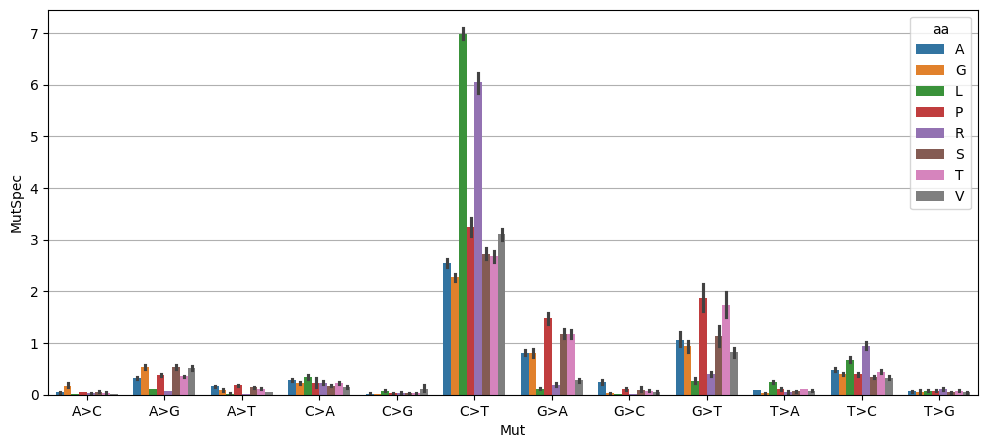

In [42]:
_ = mutspec_ff.melt(ignore_index=False, value_name='MutSpec').reset_index()
_['time_period'] = _['clade'].map(_clade2label)

plt.figure(figsize=(12, 5))
ax = sns.barplot(_, x='Mut', y='MutSpec', hue='aa') # , order=['']
plt.grid(axis='y')
ax.set_axisbelow(True)

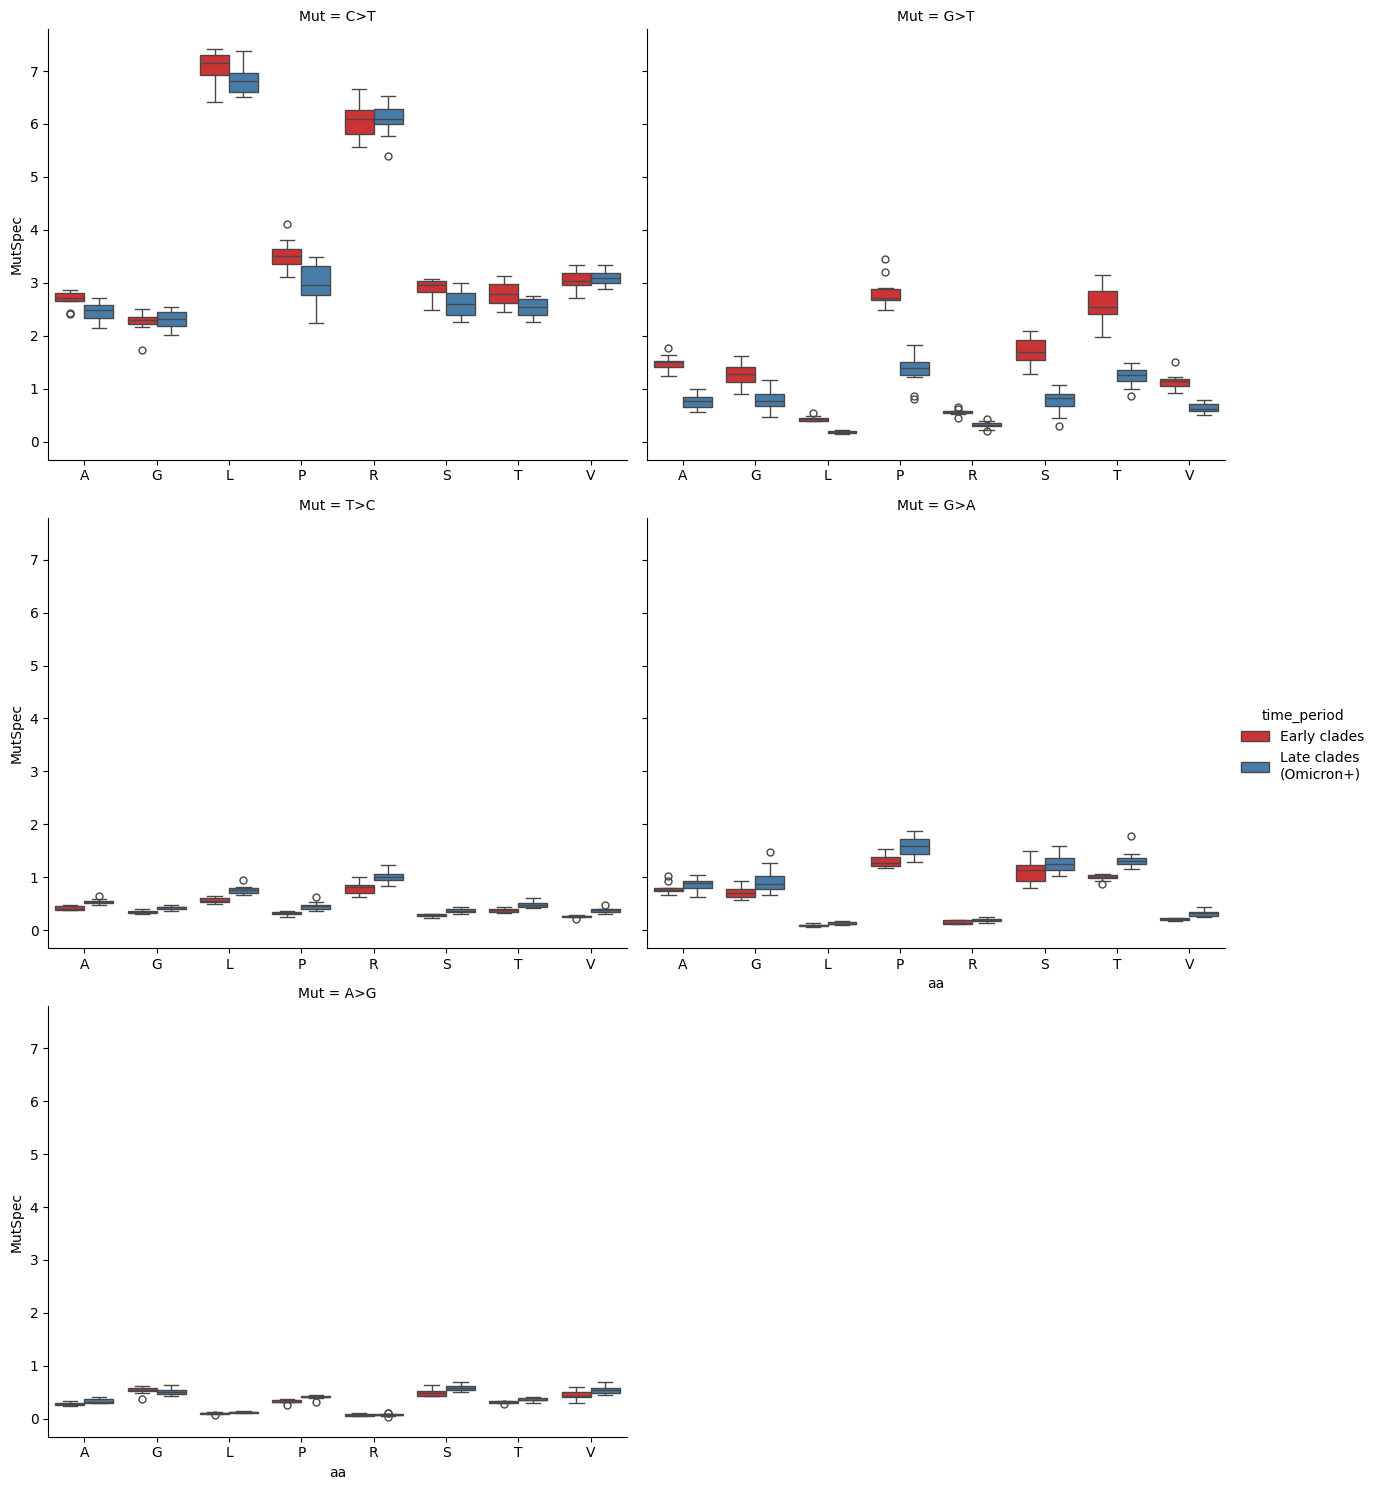

In [66]:
ax = sns.catplot(_, col='Mut', hue='time_period', y='MutSpec', x='aa', 
                 kind='box', sharey=True, sharex=False, aspect=1.25, palette='Set1',
                 col_order=['C>T', 'G>T', 'T>C', 'G>A', 'A>G'], col_wrap=2,
)
# plt.grid(axis='y')
# ax.set_axisbelow(True)

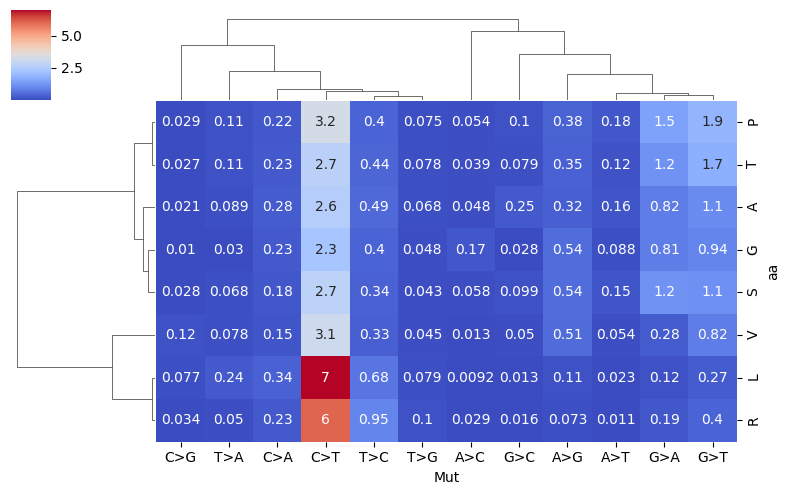

In [29]:
sns.clustermap(mutspec_ff.groupby('aa').mean(), figsize=(8,5), annot=True, cmap='coolwarm', metric='cosine', )

In [119]:
from scipy.spatial.distance import pdist, squareform
1-pdist(mutspec_ff, 'cosine')

array([0.99162422, 0.89186629, 0.98171691, 0.90514155, 0.98775146,
       0.9780994 , 0.96331089, 0.87815265, 0.97974268, 0.89079423,
       0.99337841, 0.97639126, 0.96286292, 0.81724323, 0.99769318,
       0.85248629, 0.79709655, 0.95673115, 0.83198407, 0.98894559,
       0.99839463, 0.92364787, 0.86431629, 0.81396925, 0.96113135,
       0.98432792, 0.94380743, 0.91185117])

## Spectrum of amino acid substitutions

In [21]:
def plot_exp_heatmap(exp_aa_subst_matrix: pd.DataFrame, save_path: str, show=True, annot=False):
    """
    Plot expected amino acid substitution matrix.
    """
    freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
    freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()
    max_flow_value = max(freqs_to.max(), freqs_from.max())+0.1

    fig, axs = plt.subplots(2, 3, figsize=(11, 10), 
                            width_ratios=[0.1, 1, .05], height_ratios=[1, 0.1])
    sns.heatmap(exp_aa_subst_matrix, annot=annot, fmt=".2f", 
                ax=axs[0, 1], cbar_ax=axs[0, 2], 
                cmap=sns.color_palette("light:green", as_cmap=True), 
                cbar_kws={'label': 'Substitution rate'}, vmin=0,
                mask=exp_aa_subst_matrix==0,
    )
    axs[0, 1].set_ylabel('')
    axs[0, 1].set_xlabel('')
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])
    # axs[0, 1].set_title('Expected substitution rates between amino acids')

    sns.barplot(freqs_from.reset_index(), y='aa1', x=0, ax=axs[0, 0],
                color='lightgray', edgecolor='black')
    axs[0, 0].set_ylabel('Original', fontsize=14)
    axs[0, 0].set_xlabel('Total Loss')
    axs[0, 0].spines['top'].set_visible(False)
    axs[0, 0].spines['right'].set_visible(False)
    axs[0, 0].spines['bottom'].set_visible(False)
    axs[0, 0].spines['left'].set_visible(False)
    axs[0, 0].invert_xaxis()
    axs[1, 1].set_ylim(0, max_flow_value)
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticklabels(axs[0, 0].get_yticklabels(), fontsize=12)

    sns.barplot(freqs_to.reset_index(), x='aa2', y=0, ax=axs[1, 1],
                color='lightgray', edgecolor='black')
    axs[1, 1].set_ylabel('Total Gain')
    axs[1, 1].set_xlabel('Mutant', fontsize=14)
    axs[1, 1].spines['top'].set_visible(False)
    axs[1, 1].spines['right'].set_visible(False)
    axs[1, 1].spines['bottom'].set_visible(False)
    axs[1, 1].spines['left'].set_visible(False)
    axs[1, 1].invert_yaxis()
    axs[1, 1].set_ylim(max_flow_value, 0)
    axs[1, 1].set_yticks([])
    axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), fontsize=12)

    axs[1, 0].remove()
    axs[1, 2].remove()

    plt.tight_layout()
    plt.savefig(save_path)
    if show:
        plt.show()
    else:
        plt.close(fig)

20A


/tmp/ipykernel_63679/665892802.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 0].set_yticklabels(axs[0, 0].get_yticklabels(), fontsize=12)
/tmp/ipykernel_63679/665892802.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), fontsize=12)


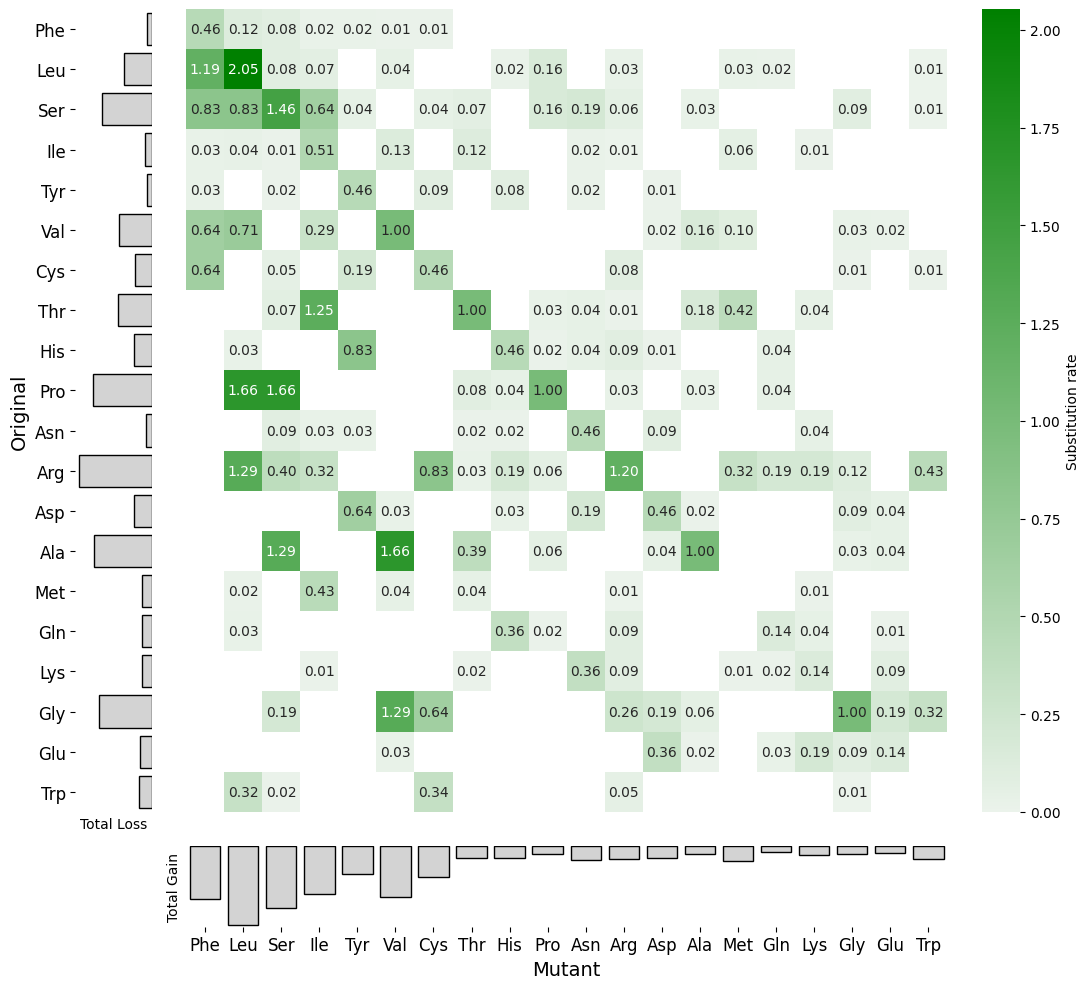

In [ ]:
print('20A')
_, exp_aa_subst_matrix = prepare_exp_aa_subst(spectrum_20A, gc=1)
_, eq_freqs_aa = get_equilibrium_freqs(spectrum_20A, 'rate', gc=1)

plot_exp_heatmap(exp_aa_subst_matrix.loc[eq_freqs_aa.aa, eq_freqs_aa.aa], 
                 'figures/exp_exp_aa_subst_matrix_20A.pdf', show=True, annot=True)

In [ ]:
freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()

_freqs_to = (freqs_to / freqs_to.sum()).copy()
_freqs_from = (freqs_from / freqs_from.sum()).copy()
_freqs_to.index.name = 'aa'
_freqs_from.index.name = 'aa'

flow20a = (_freqs_to - _freqs_from).sort_values(ascending=False).rename('Flow').reset_index()

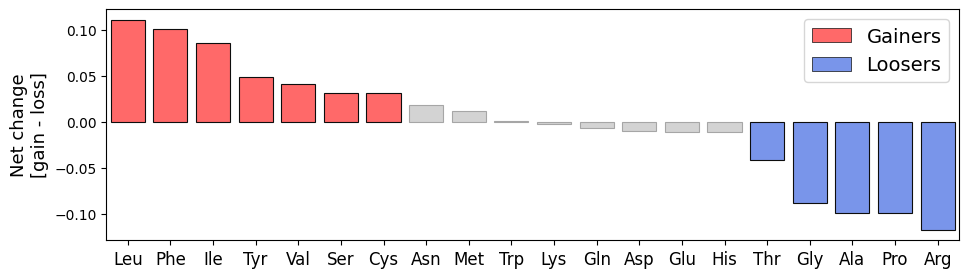

In [ ]:
plt.figure(figsize=(11, 3))
ax = sns.barplot(
    flow20a, x='aa', y='Flow', color='lightgray', edgecolor=".65", linewidth=0.8)

cutoff = flow20a.Flow.abs().max() * 0.25

for bar in ax.patches:
    if bar.get_height() > cutoff:
        bar.set_color("#ff6969")
        bar.set_edgecolor('0.05')
    elif bar.get_height() < -cutoff:
        bar.set_color('#7995ea')
        bar.set_edgecolor('0.05')
        bar.set_linewidth


plt.legend([
    plt.Rectangle((0,0),1,1,fc="#ff6969", edgecolor='.05',linewidth=0.5), 
    plt.Rectangle((0,0),1,1,fc='#7995ea', edgecolor='.05',linewidth=0.5),
    ],['Gainers', 'Loosers',], loc='upper right', fontsize=14)

# plt.title(f"{virusname}; G: {losers_gainers[i]['gainers']}; L: {losers_gainers[i]['losers']}")
plt.ylabel('Net change\n[gain - loss]', fontsize=13)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.show()

24A


/tmp/ipykernel_68146/665892802.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 0].set_yticklabels(axs[0, 0].get_yticklabels(), fontsize=12)
/tmp/ipykernel_68146/665892802.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), fontsize=12)


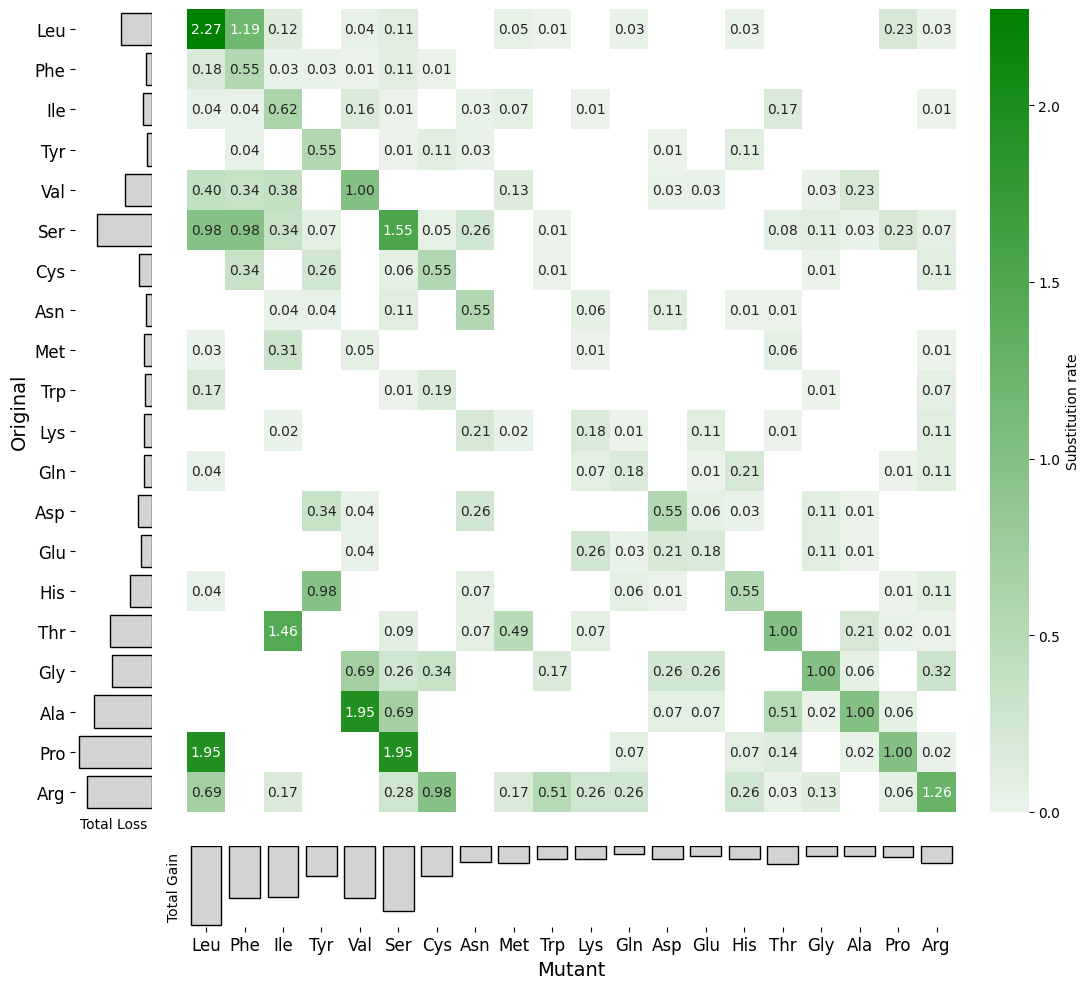

In [ ]:
print('24A')
_, exp_aa_subst_matrix = prepare_exp_aa_subst(spectrum_24A, gc=1)

freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()

_freqs_to = (freqs_to / freqs_to.sum()).copy()
_freqs_from = (freqs_from / freqs_from.sum()).copy()
_freqs_to.index.name = 'aa'
_freqs_from.index.name = 'aa'

flow24a = (_freqs_to - _freqs_from).sort_values(ascending=False).rename('Flow').reset_index()

plot_exp_heatmap(exp_aa_subst_matrix.loc[flow20a.aa, flow20a.aa], # order as in 20A
                 'figures/exp_exp_aa_subst_matrix_24A.pdf', show=True, annot=True)

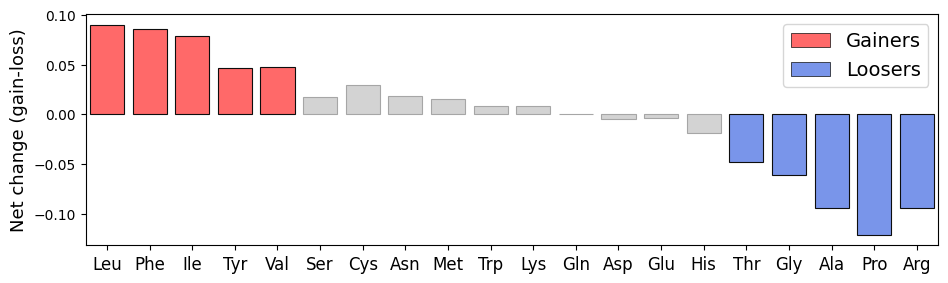

In [ ]:
plt.figure(figsize=(11, 3))
ax = sns.barplot(
    flow24a, x='aa', y='Flow', order=flow20a.aa,
    color='lightgray', edgecolor=".65", linewidth=0.8)

cutoff = flow24a.Flow.abs().max() * 0.25

for bar in ax.patches:
    if bar.get_height() > cutoff:
        bar.set_color("#ff6969")
        bar.set_edgecolor('0.05')
    elif bar.get_height() < -cutoff:
        bar.set_color('#7995ea')
        bar.set_edgecolor('0.05')
        bar.set_linewidth


plt.legend([
    plt.Rectangle((0,0),1,1,fc="#ff6969", edgecolor='.05',linewidth=0.5), 
    plt.Rectangle((0,0),1,1,fc='#7995ea', edgecolor='.05',linewidth=0.5),
    ],['Gainers', 'Loosers',], loc='upper right', fontsize=14)

# plt.title(f"{virusname}; G: {losers_gainers[i]['gainers']}; L: {losers_gainers[i]['losers']}")
plt.ylabel('Net change (gain-loss)', fontsize=13)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.show()

## Calculate amino acid equilibrium frequencies

In [10]:
## Calculate codon and AA equilibrium frequencies
eq_freqs_cdn, eq_freqc_aa = get_equilibrium_freqs(spectrum_20A, 'rate', gc=1)
eq_freqs_cdn.to_csv('./data/20A/cdn_eq_freqs.csv', index=False, float_format='%g')
eq_freqc_aa.to_csv('./data/20A/aa_eq_freqs.csv', index=False, float_format='%g')
eq_freqs_cdn

,cdn,eq_freq,aa
0,AAA,0.003032,Lys
1,AAC,0.003836,Asn
2,AAG,0.001522,Lys
3,AAT,0.012910,Asn
4,ACA,0.003836,Thr
...,...,...,...
59,TGT,0.029462,Cys
60,TTA,0.054818,Leu
61,TTC,0.074299,Phe
62,TTG,0.029462,Leu


In [11]:
eq_freqc_aa['obs_freq'] = eq_freqc_aa['aa'].map(aa_freqs_total_dct)
eq_freqc_aa['obs_freq'] /= eq_freqc_aa['obs_freq'].sum()
eq_freqc_aa['delta'] = (eq_freqc_aa['eq_freq'] - eq_freqc_aa['obs_freq']) / eq_freqc_aa[['eq_freq', 'obs_freq']].max(1)
eq_freqc_aa.sort_values('delta', ascending=False)

,aa,eq_freq,obs_freq,delta
0,Phe,0.314637,0.051395,0.836653
1,Leu,0.197825,0.095404,0.517735
2,Ser,0.119281,0.067809,0.431520
3,Ile,0.086898,0.052626,0.394393
4,Tyr,0.073639,0.045958,0.375899
6,Cys,0.035283,0.030365,0.139373
8,His,0.020183,0.019389,0.039367
5,Val,0.044165,0.080222,-0.449467
9,Pro,0.017862,0.040419,-0.558086
7,Thr,0.025257,0.073656,-0.657102


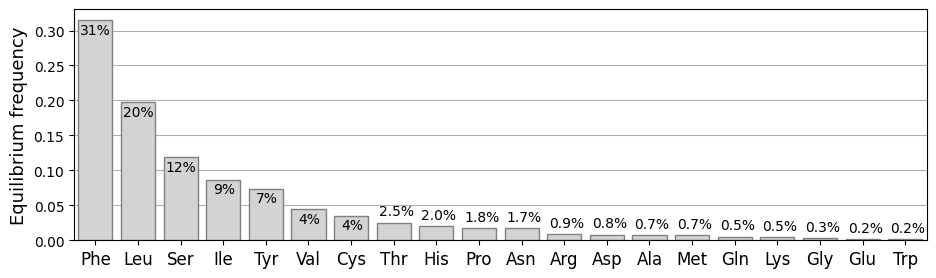

In [12]:
plt.figure(figsize=(11, 3))
ax=sns.barplot(eq_freqc_aa, x='aa', y='eq_freq', color='lightgray', edgecolor='gray')

for i, aa in enumerate(eq_freqc_aa.aa):
    f = eq_freqc_aa.query('aa == @aa').eq_freq.item()
    x = i-0.35
    if f < 0.03:
        lbl = f"{f*100:.1f}%" 
        y = f + 0.01
    elif f < 0.1:
        lbl = f"{f*100:.0f}%"
        y = f - 0.02
        x = i-0.24
    else:
        lbl = f"{f*100:.0f}%"
        y = f - 0.02
    ax.text(x, y, lbl)

plt.ylabel('Equilibrium frequency', fontsize=13)
plt.xticks(fontsize=12)
plt.xlabel('')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

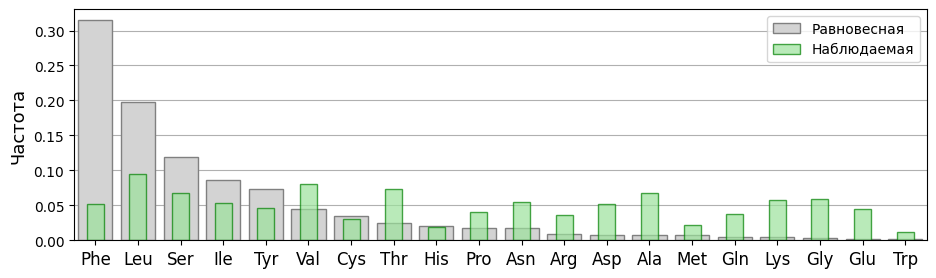

In [ ]:
plt.figure(figsize=(11, 3))
ax=sns.barplot(eq_freqc_aa, x='aa', y='eq_freq', color='lightgray', edgecolor='gray', 
               label='Equilibrium')
ax=sns.barplot(eq_freqc_aa, x='aa', y='obs_freq', color='lightgreen', edgecolor='green', 
               width=0.4, alpha=0.7, label='Observed')

plt.ylabel('Frequency', fontsize=13)
plt.xticks(fontsize=12)
plt.xlabel('')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.savefig('figures/20A_aa_eq_vs_obs_freqs.pdf')
plt.show()

Phe, Leu, Ser, Ile, Tyr, Cys and His - Global Gainers

Other AA - Global Losers

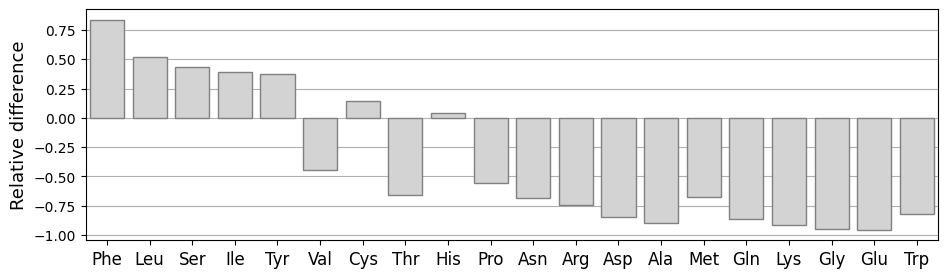

In [24]:
plt.figure(figsize=(11, 3))
ax=sns.barplot(eq_freqc_aa, x='aa', y='delta', color='lightgray', edgecolor='gray')
plt.ylabel('Relative difference', fontsize=13)
plt.xticks(fontsize=12)
plt.xlabel('')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.show()